# [과제 2] 회귀분석
### - Ch 1, Ch 2를 토대로 자유롭게 회귀분석과 회귀진단을 진행해주세요.
### - 주석으로 설명 및 근거 자세하게 달아주시면 감사하겠습니다. :)

In [1]:
%matplotlib inline 

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings(action='ignore')

In [66]:
!pip install statsmodels

In [68]:
!pip install scipy.signal.signaltools

ERROR: Could not find a version that satisfies the requirement scipy.signal.signaltools
ERROR: No matching distribution found for scipy.signal.signaltools


In [73]:

#머신러닝 모델 구축 / 평가
import scipy as sp
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.formula.api import ols

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

#데이터 시각화
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

#한글 폰트
plt.style.use('seaborn')
plt.rc('font', family='DejaVu Sans')
plt.rc('axes', unicode_minus=False)

# Data 

데이터 출처 : https://www.kaggle.com/avikasliwal/used-cars-price-prediction 

< y > 
* **Price** : The price of the used car in INR Lakhs.



< X > 
* Name : The brand and model of the car
* Location : The location in which the car is being sold or is available for purchase.
* Year : The year or edition of the model.
* Kilometers_Driven : The total kilometres driven in the car by the previous owner(s) in KM.
* Fuel_Type : The type of fuel used by the car. (Petrol, Diesel, Electric, CNG, LPG)
* Transmission : The type of transmission used by the car. (Automatic / Manual)
* Owner_Type : Whether the ownership is Firsthand, Second hand or other.
* Mileage : The standard mileage offered by the car company in kmpl or km/kg
* Engine : The displacement volume of the engine in CC.
* Power : The maximum power of the engine in bhp.
* Seats : The number of seats in the car.
* New_Price : The price of a new car of the same model.

In [43]:
# Load Data 
data = pd.read_csv("assignment2_data.csv")
data.head()

,Unnamed: 0,Name,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Mileage,Engine,Power,Seats,New_Price,Price
0,0,Maruti Wagon R LXI CNG,Mumbai,2010,72000,CNG,Manual,First,26.6 km/kg,998 CC,58.16 bhp,5.0,NaN,1.75
1,1,Hyundai Creta 1.6 CRDi SX Option,Pune,2015,41000,Diesel,Manual,First,19.67 kmpl,1582 CC,126.2 bhp,5.0,NaN,12.50
2,2,Honda Jazz V,Chennai,2011,46000,Petrol,Manual,First,18.2 kmpl,1199 CC,88.7 bhp,5.0,8.61 Lakh,4.50
3,3,Maruti Ertiga VDI,Chennai,2012,87000,Diesel,Manual,First,20.77 kmpl,1248 CC,88.76 bhp,7.0,NaN,6.00
4,4,Audi A4 New 2.0 TDI Multitronic,Coimbatore,2013,40670,Diesel,Automatic,Second,15.2 kmpl,1968 CC,140.8 bhp,5.0,NaN,17.74


In [44]:
data.columns

Index(['Unnamed: 0', 'Name', 'Location', 'Year', 'Kilometers_Driven',
       'Fuel_Type', 'Transmission', 'Owner_Type', 'Mileage', 'Engine', 'Power',
       'Seats', 'New_Price', 'Price'],
      dtype='object')

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


In [46]:
data.isnull().sum()

Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

전처리

In [47]:
data = data[data['Mileage'].notna()] #notna() : 누락값 여부 체크
data = data[data['Engine'].notna()]
data = data[data['Power'].notna()]
data = data[data['Seats'].notna()]
data = data.reset_index(drop=True)

In [48]:
for i in range(data.shape[0]):
    data.at[i, 'Mileage(km/kg)'] = data['Mileage'][i].split()[0] #mileage의 숫자부분만 가져오기
    data.at[i, 'Engine(CC)'] = data['Engine'][i].split()[0] #engine의 숫자부분만 가져오기
    data.at[i, 'Power(bhp)'] = data['Power'][i].split()[0] #power의 숫자부분만 가져오기

In [49]:
(data['Power'] == 'null bhp').value_counts()
#power에 null bhp인 값들이 103개가 존재한다

False    5872
True      103
Name: Power, dtype: int64

In [50]:
x = 'n'
count = 0
position = []
for i in range(data.shape[0]):
    if data['Power(bhp)'][i]=='null':
        x = 'Y'
        count = count + 1
        position.append(i)

data = data.drop(data.index[position]) # 그리고 그 값을 삭제해주기
data = data.reset_index(drop=True)

In [51]:
data['Mileage(km/kg)'] = data['Mileage(km/kg)'].astype(float)
data['Engine(CC)'] = data['Engine(CC)'].astype(float)
data['Power(bhp)'] = data['Power(bhp)'].astype(float)

In [52]:
for i in range(data.shape[0]):
    if pd.isnull(data.loc[i,'New_Price']) == False: #New_Price의 값이 존재하면 숫자부분만 가져오기
        data.at[i,'New_car_Price'] = data['New_Price'][i].split()[0]

In [53]:
data['New_car_Price'] = data['New_car_Price'].astype(float)

In [54]:
data.drop(["Name","Mileage","Engine","Power","New_Price"],axis=1,inplace=True)

In [55]:
data.head()

,Unnamed: 0,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Mileage(km/kg),Engine(CC),Power(bhp),New_car_Price
0,0,Mumbai,2010,72000,CNG,Manual,First,5.0,1.75,26.60,998.0,58.16,NaN
1,1,Pune,2015,41000,Diesel,Manual,First,5.0,12.50,19.67,1582.0,126.20,NaN
2,2,Chennai,2011,46000,Petrol,Manual,First,5.0,4.50,18.20,1199.0,88.70,8.61
3,3,Chennai,2012,87000,Diesel,Manual,First,7.0,6.00,20.77,1248.0,88.76,NaN
4,4,Coimbatore,2013,40670,Diesel,Automatic,Second,5.0,17.74,15.20,1968.0,140.80,NaN


In [56]:
Location = pd.get_dummies(data[['Location']],drop_first=True)

Fuel_t = pd.get_dummies(data[['Fuel_Type']],drop_first=True)

Transmission = pd.get_dummies(data[['Transmission']],drop_first=True)

data.replace({"First":1,"Second":2,"Third": 3,"Fourth & Above":4},inplace=True)

data.head()

,Unnamed: 0,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Mileage(km/kg),Engine(CC),Power(bhp),New_car_Price
0,0,Mumbai,2010,72000,CNG,Manual,1,5.0,1.75,26.60,998.0,58.16,NaN
1,1,Pune,2015,41000,Diesel,Manual,1,5.0,12.50,19.67,1582.0,126.20,NaN
2,2,Chennai,2011,46000,Petrol,Manual,1,5.0,4.50,18.20,1199.0,88.70,8.61
3,3,Chennai,2012,87000,Diesel,Manual,1,7.0,6.00,20.77,1248.0,88.76,NaN
4,4,Coimbatore,2013,40670,Diesel,Automatic,2,5.0,17.74,15.20,1968.0,140.80,NaN


In [57]:
final_data= pd.concat([data,Location,Fuel_t,Transmission],axis=1)
final_data.head()

,Unnamed: 0,Location,Year,Kilometers_Driven,Fuel_Type,Transmission,Owner_Type,Seats,Price,Mileage(km/kg),...,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual
0,0,Mumbai,2010,72000,CNG,Manual,1,5.0,1.75,26.60,...,0,0,0,0,1,0,0,0,0,1
1,1,Pune,2015,41000,Diesel,Manual,1,5.0,12.50,19.67,...,0,0,0,0,0,1,1,0,0,1
2,2,Chennai,2011,46000,Petrol,Manual,1,5.0,4.50,18.20,...,0,0,0,0,0,0,0,0,1,1
3,3,Chennai,2012,87000,Diesel,Manual,1,7.0,6.00,20.77,...,0,0,0,0,0,0,1,0,0,1
4,4,Coimbatore,2013,40670,Diesel,Automatic,2,5.0,17.74,15.20,...,0,0,0,0,0,0,1,0,0,0


In [58]:
final_data.drop(["Location","Fuel_Type","Transmission","New_car_Price"],axis=1,inplace=True)
final_data.head()

,Unnamed: 0,Year,Kilometers_Driven,Owner_Type,Seats,Price,Mileage(km/kg),Engine(CC),Power(bhp),Location_Bangalore,...,Location_Hyderabad,Location_Jaipur,Location_Kochi,Location_Kolkata,Location_Mumbai,Location_Pune,Fuel_Type_Diesel,Fuel_Type_LPG,Fuel_Type_Petrol,Transmission_Manual
0,0,2010,72000,1,5.0,1.75,26.60,998.0,58.16,0,...,0,0,0,0,1,0,0,0,0,1
1,1,2015,41000,1,5.0,12.50,19.67,1582.0,126.20,0,...,0,0,0,0,0,1,1,0,0,1
2,2,2011,46000,1,5.0,4.50,18.20,1199.0,88.70,0,...,0,0,0,0,0,0,0,0,1,1
3,3,2012,87000,1,7.0,6.00,20.77,1248.0,88.76,0,...,0,0,0,0,0,0,1,0,0,1
4,4,2013,40670,2,5.0,17.74,15.20,1968.0,140.80,0,...,0,0,0,0,0,0,1,0,0,0


In [59]:
X = final_data.drop(['Unnamed: 0','Price'],axis=1)
y = final_data[['Price']]

In [63]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2021)

### 선형회귀모델 가정확인

In [72]:
import  scipy.signal.signaltools

def _centered(arr, newsize):
    # Return the center newsize portion of the array.
    newsize = np.asarray(newsize)
    currsize = np.array(arr.shape)
    startind = (currsize - newsize) // 2
    endind = startind + newsize
    myslice = [slice(startind[k], endind[k]) for k in range(len(endind))]
    return arr[tuple(myslice)]

scipy.signal.signaltools._centered = _centered

In [74]:
import statsmodels.api as sm
X_train=sm.add_constant(X_train) #beta_0 값이 될 변수 만들기
model=sm.OLS(y_train,X_train,axis=1)
model_trained=model.fit()

**정규성 확인**

확률오차가 정규성을 나름 잘 따라 가는 것 같음

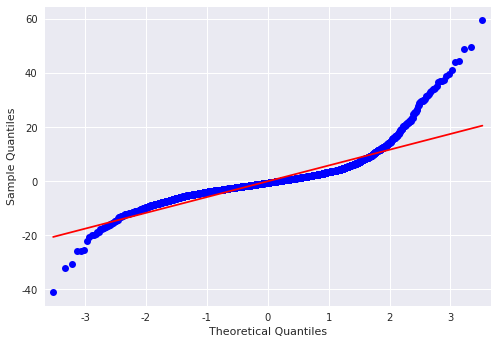

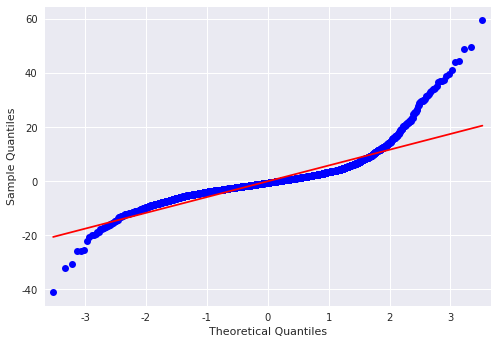

In [75]:
model_residuals=model_trained.resid

plt.rcParams["axes.unicode_minus"]=False #폰트 깨짐 방지
sm.ProbPlot(model_residuals).qqplot(line="s")

**등분산성 확인**

분산이 점점 커지는 형태로 보아 등분산성 만족 못하는 것 같음

Text(0, 0.5, 'residuals')

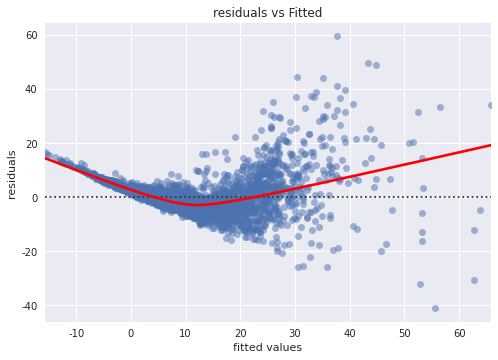

In [76]:
model_fitted_y=model_trained.fittedvalues

sns.residplot(model_fitted_y, y_train,data=X_train, lowess=True, scatter_kws={"alpha":0.5},line_kws={"color":"red"})

plt.title("residuals vs Fitted")
plt.xlabel("fitted values")
plt.ylabel("residuals")

y의 로그변환을 해주었고 결과 확인시 등분산성을 만족하므로 y는 log 변환을 해주기로 한다

Text(0, 0.5, 'residuals')

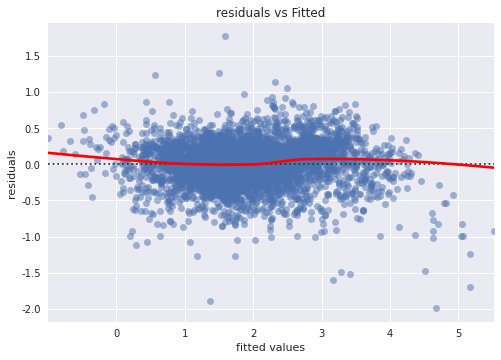

In [79]:
X_train=sm.add_constant(X_train) #beta_0 값이 될 변수 만들기
log_model=sm.OLS(np.log(y_train),X_train,axis=1)
log_model_trained=log_model.fit()

log_model_fitted_y=log_model_trained.fittedvalues

sns.residplot(log_model_fitted_y, np.log(y_train),data=X_train, lowess=True, scatter_kws={"alpha":0.5},line_kws={"color":"red"})

plt.title("residuals vs Fitted")
plt.xlabel("fitted values")
plt.ylabel("residuals")

### 설명 : 통계적인 해석
* R-squared : 모형의 성능
* coef (회귀계수) : X가 1 단위 증가함에 따른 y의 변화량
* p-value : 0.05 (유의 수준) 이하일 때 변수 유의미

In [80]:
print(log_model_trained.summary()) #통계량 제공됨

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     1725.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:32:31   Log-Likelihood:                -864.45
No. Observations:                4697   AIC:                             1773.
Df Residuals:                    4675   BIC:                             1915.
Df Model:                          21                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -250.6709    

상대적으로 p-value 값이 높은 변수 값 제거 : 'Kilometers_Driven','Seats', 'Location_Chennai','Location_Kochi', 'Fuel_Type_LPG'

In [81]:
log_model=sm.OLS(np.log(y_train),X_train.drop(['Kilometers_Driven','Seats', 'Location_Chennai','Location_Kochi', 'Fuel_Type_LPG'],axis=1))
log_model_trained=log_model.fit()
print(log_model_trained.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                     2262.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:34:40   Log-Likelihood:                -868.60
No. Observations:                4697   AIC:                             1771.
Df Residuals:                    4680   BIC:                             1881.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                -250.6346    

## chp2 다중공선성 검사

In [103]:
# VIF check 
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif["features"] = X.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
0,386.808640,Year
3,79.898587,Seats
5,75.438171,Engine(CC)
17,60.604214,Fuel_Type_Diesel
19,52.607187,Fuel_Type_Petrol
4,51.363552,Mileage(km/kg)
6,36.997675,Power(bhp)
2,9.065694,Owner_Type
20,6.331967,Transmission_Manual
15,4.579068,Location_Mumbai


의심되는 변수: const, Fule_Type_Petrol, Fuel_Type_Diesel

In [114]:
X2 = X.drop(['Year','Engine(CC)','Seats','Fuel_Type_Diesel','Mileage(km/kg)'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X2.values, i) for i in range(X2.shape[1])]
vif["features"] = X2.columns
vif.sort_values(["VIF Factor"], ascending=[False])

,VIF Factor,features
1,7.940987,Owner_Type
2,6.905753,Power(bhp)
15,4.385965,Transmission_Manual
11,2.929601,Location_Mumbai
7,2.608949,Location_Hyderabad
12,2.538211,Location_Pune
9,2.495157,Location_Kochi
5,2.489009,Location_Coimbatore
6,2.347907,Location_Delhi
4,2.250325,Location_Chennai


In [119]:
X_2 = X.drop(['Year','Engine(CC)','Seats','Fuel_Type_Diesel','Mileage(km/kg)'], axis=1)
X_train2,X_test2,y_train2,y_test2=train_test_split(X_2,y,test_size=0.2,random_state=2021)

X_train2=sm.add_constant(X_train2) #beta_0 값이 될 변수 만들기
log_model=sm.OLS(np.log(y_train2),X_train2,axis=1)
log_model_trained=log_model.fit()
print(log_model_trained.summary()) #통계량 제공됨

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.743
Model:                            OLS   Adj. R-squared:                  0.742
Method:                 Least Squares   F-statistic:                     844.9
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:55:38   Log-Likelihood:                -2768.8
No. Observations:                4697   AIC:                             5572.
Df Residuals:                    4680   BIC:                             5681.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.7291    

In [120]:
X_2 = X.drop(['Year','Engine(CC)','Seats','Fuel_Type_Diesel','Mileage(km/kg)'], axis=1)
X_train2,X_test2,y_train2,y_test2=train_test_split(X_2,y,test_size=0.2,random_state=2021)

X_train2=sm.add_constant(X_train2) #beta_0 값이 될 변수 만들기
log_model=sm.OLS(np.log(y_train2),X_train2,axis=1)
log_model_trained=log_model.fit()

log_model_fitted_y=log_model_trained.fittedvalues

log_model=sm.OLS(np.log(y_train2),X_train2.drop(['Location_Chennai','Location_Delhi','Location_Hyderabad', 'Location_Mumbai'],axis=1))
log_model_trained=log_model.fit()
print(log_model_trained.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.742
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     1124.
Date:                Tue, 02 Aug 2022   Prob (F-statistic):               0.00
Time:                        14:56:30   Log-Likelihood:                -2775.0
No. Observations:                4697   AIC:                             5576.
Df Residuals:                    4684   BIC:                             5660.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.7239    

### **예측 : 미래의 반응변수 값 예측** (다중공선성 처리 전)

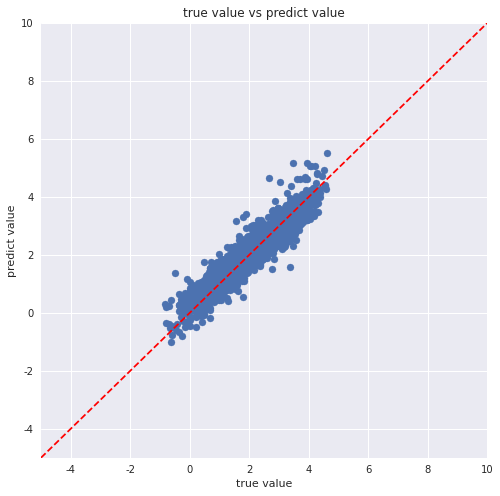

In [86]:
#train하는 부분
y_train_pred=log_model_trained.fittedvalues

plt.figure(figsize=(8,8))
plt.title("true value vs predict value")
plt.scatter(np.log(y_train),y_train_pred)
plt.plot([-5,10],[-5,10],ls="--",c="red")
plt.xlabel("true value")
plt.ylabel("predict value")
plt.xlim(-5,10)
plt.ylim(-5,10)
plt.show()

#일직선을 따르므로 정확한 예측을 함

**test-set에 대해 진행**

In [87]:
X_test=sm.add_constant(X_test)
y_test_pred=log_model_trained.predict(X_test.drop(['Kilometers_Driven','Seats', 'Location_Chennai','Location_Kochi', 'Fuel_Type_LPG'],axis=1))
y_test_pred.head()

1929    1.793135
1937    2.828946
4992    2.777147
2743    1.873878
4341    1.301288
dtype: float64

**평균제곱오차**

In [88]:
print(mean_squared_error(np.log(y_test),y_test_pred))

0.09690774298566589


**제곱근 평균 제곱 오차**

In [89]:
print(np.sqrt(mean_squared_error(np.log(y_test),y_test_pred)))

0.31130008510385265


**평균 절대 오차**

In [90]:
print(mean_absolute_error(np.log(y_test),y_test_pred))

0.2254152712355099


**평균 절대 백분율 오차**

In [93]:
def mean_absolute_percentage_error(y_true,y_pred):
  y_true,y_pred=np.array(y_true),np.array(y_pred)
  return np.mean(np.abs((np.log(y_true)-y_pred)/y_true))*100

print(mean_absolute_error(y_test,y_test_pred))

7.7301263408642


### **예측 : 미래의 반응변수 값 예측** (다중공선성 처리 후)

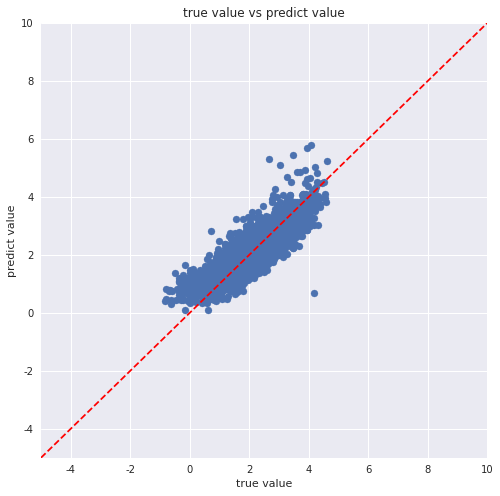

In [122]:
#train하는 부분
log_model=sm.OLS(np.log(y_train2),X_train2.drop(['Location_Chennai','Location_Delhi','Location_Hyderabad', 'Location_Mumbai'],axis=1))
log_model_trained=log_model.fit()
y_train_pred=log_model_trained.fittedvalues

plt.figure(figsize=(8,8))
plt.title("true value vs predict value")
plt.scatter(np.log(y_train2),y_train_pred)
plt.plot([-5,10],[-5,10],ls="--",c="red")
plt.xlabel("true value")
plt.ylabel("predict value")
plt.xlim(-5,10)
plt.ylim(-5,10)
plt.show()

#일직선을 따르므로 정확한 예측을 함

**test-set에 대해 진행**

In [124]:
X_test2=sm.add_constant(X_test2)
y_test_pred=log_model_trained.predict(X_test2.drop(['Location_Chennai','Location_Delhi','Location_Hyderabad', 'Location_Mumbai'],axis=1))
y_test_pred.head()

1929    2.131713
1937    3.026763
4992    2.422323
2743    1.616382
4341    1.163642
dtype: float64

**평균제곱오차**

In [126]:
print(mean_squared_error(np.log(y_test2),y_test_pred))

0.19870709780357085


**제곱근 평균 제곱 오차**

In [127]:
print(mean_absolute_error(np.log(y_test2),y_test_pred))

0.34331757542188573


다중공선성 처리 안 해준게 오차의 값이 더 낮다